In [225]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss


# 1) Win classifier

In [226]:
from hyperopt import fmin, tpe, hp, anneal, Trials
from sklearn.compose import ColumnTransformer
import joblib
from sklearn.impute import SimpleImputer

In [235]:
## read in the dataset
df = pd.read_csv('../data/2024/model_data/matchup_features.csv')
X = df[[x for x in df.columns if x != 'diff_score']]
y = df['diff_score']
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)


numerics = [x for x in df.columns if x not in ['diff_score','Season','TeamID_1','TeamID_2','Seed_1','Seed_2'] and 'diff_' in x]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    [("numerics",numeric_transformer,numerics)]
)


In [228]:
def gb_mse_cv(params, random_state=42):
    
    
    # the function gets a set of variable parameters in "param"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']),
              'min_child_weight': params['min_child_weight'],
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree'],
              'colsample_bynode': params['colsample_bynode'],
              'eta': params['eta'],
              'gamma': params['gamma'],
              'reg_lambda': params['reg_lambda'],
              'reg_alpha': params['reg_alpha']             
             }
    


    model = XGBRegressor(random_state=random_state,verbosity=0, **params)    
    pipe = Pipeline([('preprocessor', preprocessor), ('model', model)])
    
    # and then conduct the cross validation with the same folds as before
    score = -cross_val_score(pipe, X_train, y_train, cv=KFold(3), scoring="neg_root_mean_squared_error").mean()

    return score

In [229]:
# possible values of parameters
space={'n_estimators': hp.quniform('n_estimators', 64, 128, 1),
       'max_depth' : hp.quniform('max_depth', 1, 15, 1),
       'min_child_weight': hp.quniform('min_child_weight', 1, 100, 1),
       'subsample': hp.uniform('subsample',0.3,1),
       'colsample_bytree': hp.uniform('colsample_bytree',0.3,1),
       'colsample_bynode': hp.uniform('colsample_bynode',0.3,1),
       'eta': hp.loguniform('eta', -5, -1),
       'gamma': hp.uniform('gamma', 0,20),
       'reg_lambda': hp.loguniform('reg_lambda',0,7),
       'reg_alpha': hp.uniform('reg_alpha',0,100)       
      }

# trials will contain logging information
trials = Trials()

best=fmin(fn=gb_mse_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=100, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(42) # fixing random state for the reproducibility
         )

print(best)

100%|██████████| 100/100 [01:45<00:00,  1.05s/trial, best loss: 11.060670366982174]
{'colsample_bynode': 0.9499931783470599, 'colsample_bytree': 0.7199191298941757, 'eta': 0.036856341431951815, 'gamma': 0.4798977194094103, 'max_depth': 2.0, 'min_child_weight': 64.0, 'n_estimators': 118.0, 'reg_alpha': 25.70437965964932, 'reg_lambda': 8.646840779113285, 'subsample': 0.5813365999495217}


In [237]:
xgb_reg = XGBRegressor(
    verbosity=0,
    colsample_bytree= best['colsample_bytree'],
    eta = best['eta'],
    gamma = best['gamma'],
    max_depth = int(best['max_depth']),
    min_child_weight = best['min_child_weight'],
    n_estimators = int(best['n_estimators']),
    reg_alpha = best['reg_alpha'],
    reg_lambda = best['reg_lambda'],
    subsample = best['subsample'] 
)

In [238]:
reg_pipe = Pipeline([('preprocessor', preprocessor), ('model', xgb_reg)])

In [239]:
reg_pipe.fit(X_train, y_train)
print(reg_pipe.score(X_train,y_train))
print(reg_pipe.score(X_test,y_test))

0.45098184894678883
0.40198468386822617


In [233]:
feature_importance_df = pd.DataFrame(zip(numerics,reg_pipe['model'].feature_importances_),columns=['Feature','Importance'])
feature_importance_df.sort_values(by='Importance',inplace=True,ascending=False)
feature_importance_df.head(60)

,Feature,Importance
59,diff_prev_pom,0.134211
58,diff_final_pom,0.130888
25,diff_pi_i,0.084612
12,diff_sw16_car,0.074774
56,diff_prev_net,0.046752
1,diff_is_ap_pre_top_15,0.034826
55,diff_final_net,0.031603
15,diff_preseason_pts,0.026398
10,diff_coach_wl_car,0.024247
13,diff_ff_car,0.019954


In [240]:
joblib.dump(reg_pipe, '../models/2024/xgb_spread_pipeline_v01.joblib')

['../models/2024/xgb_spread_pipeline_v01.joblib']

# Classifier

In [222]:
## read in the dataset
# df = pd.read_csv('../data/2024/model_data/matchup_features.csv')
# X = df[[x for x in df.columns if x != 'diff_score']]
# y = df['diff_score'].map(lambda x: int(x>0))
# train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42,stratify=y)
X_train['pred_diff_score'] = reg_pipe.predict(X_train)
X_test['pred_diff_score'] = reg_pipe.predict(X_test)
y_train = y_train.map(lambda x: int(x>0))
y_test = y_test.map(lambda x: int(x>0))



numerics = [x for x in df.columns if x not in ['diff_score','Season','TeamID_1','TeamID_2','Seed_1','Seed_2'] and 'diff_' in x] # and x in ['diff_'+y for y in diff_cols]]
# numerics += ['pred_diff_score']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    [("numerics",numeric_transformer,numerics)]
)


In [223]:
def gb_mse_cv(params, random_state=42):
    
    
    # the function gets a set of variable parameters in "param"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']),
              'min_child_weight': params['min_child_weight'],
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree'],
              'eta': params['eta'],
              'gamma': params['gamma'],
              'reg_lambda': params['reg_lambda'],
              'reg_alpha': params['reg_alpha']             
             }
    


    model = XGBClassifier(random_state=random_state,verbosity=0, **params)    
    pipe = Pipeline([('preprocessor', preprocessor), ('model', model)])
    
    # and then conduct the cross validation with the same folds as before
    score = -cross_val_score(pipe, X_train, y_train, cv=StratifiedKFold(3), scoring="neg_log_loss").mean()

    return score

In [224]:
# possible values of parameters
space={'n_estimators': hp.quniform('n_estimators', 64, 128, 1),
       'max_depth' : hp.quniform('max_depth', 3, 20, 1),
       'min_child_weight': hp.quniform('min_child_weight', 1, 40, 1),
       'subsample': hp.uniform('subsample',0.5,1),
       'colsample_bytree': hp.uniform('colsample_bytree',0.5,1),
       'eta': hp.loguniform('eta', -5, -1),
       'gamma': hp.uniform('gamma', 0,20),
       'reg_lambda': hp.loguniform('reg_lambda',0,7),
       'reg_alpha': hp.uniform('reg_alpha',0,100)       
      }

# trials will contain logging information
trials = Trials()

best=fmin(fn=gb_mse_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=100, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(42) # fixing random state for the reproducibility
         )

print(best)

100%|██████████| 100/100 [2:18:13<00:00, 82.93s/trial, best loss: 0.5320177801490275]    
{'colsample_bytree': 0.8546129973808382, 'eta': 0.0667542673003125, 'gamma': 2.1631001346226353, 'max_depth': 19.0, 'min_child_weight': 18.0, 'n_estimators': 117.0, 'reg_alpha': 4.364779874082793, 'reg_lambda': 6.851539780836213, 'subsample': 0.6000357667820124}


In [166]:
# possible values of parameters
space={'n_estimators': hp.quniform('n_estimators', 64, 128, 1),
       'max_depth' : hp.quniform('max_depth', 3, 20, 1),
       'min_child_weight': hp.quniform('min_child_weight', 1, 40, 1),
       'subsample': hp.uniform('subsample',0.5,1),
       'colsample_bytree': hp.uniform('colsample_bytree',0.5,1),
       'eta': hp.loguniform('eta', -5, -1),
       'gamma': hp.uniform('gamma', 0,20),
       'reg_lambda': hp.loguniform('reg_lambda',0,7),
       'reg_alpha': hp.uniform('reg_alpha',0,100)       
      }

# trials will contain logging information
trials = Trials()

best=fmin(fn=gb_mse_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=100, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(42) # fixing random state for the reproducibility
         )

print(best)

100%|██████████| 100/100 [01:53<00:00,  1.14s/trial, best loss: 0.5335255262589969]
{'colsample_bytree': 0.6794169625830152, 'eta': 0.04957086734749227, 'gamma': 6.81848989096027, 'max_depth': 12.0, 'min_child_weight': 25.0, 'n_estimators': 68.0, 'reg_alpha': 0.23248513873374, 'reg_lambda': 1.8454906535222741, 'subsample': 0.6321096336124826}


In [217]:
xgb_clf = XGBClassifier(
    verbosity=0,
    colsample_bytree= best['colsample_bytree'],
    eta = best['eta'],
    gamma = best['gamma'],
    max_depth = int(best['max_depth']),
    min_child_weight = best['min_child_weight'],
    n_estimators = int(best['n_estimators']),
    reg_alpha = best['reg_alpha'],
    reg_lambda = best['reg_lambda'],
    subsample = best['subsample'] 
)

In [218]:
pipe = Pipeline([('preprocessor', preprocessor), ('model', xgb_clf)])

In [219]:
pipe.fit(X_train, y_train)
print(pipe.score(X_train,y_train))
print(pipe.score(X_test,y_test))

0.8232135481206113
0.7360594795539034


In [220]:
preds_test = pipe.predict_proba(X_test)[:,1]
score = log_loss(y_test, preds_test)
print(score)

0.5301191673252981


In [169]:
pipe.fit(X_train, y_train)
print(pipe.score(X_train,y_train))
print(pipe.score(X_test,y_test))

0.7575382073523338
0.758364312267658


In [122]:
# import os
# os.makedirs('../models/2024/')
# joblib.dump(pipe, '../models/2024/xgb_pipeline_v01.joblib')

In [221]:
feature_importance_df = pd.DataFrame(zip(numerics,pipe['model'].feature_importances_),columns=['Feature','Importance'])
feature_importance_df.sort_values(by='Importance',inplace=True,ascending=False)
feature_importance_df.head(60)

,Feature,Importance
61,pred_diff_score,0.096997
58,diff_final_pom,0.089381
55,diff_final_net,0.049117
12,diff_sw16_car,0.037000
25,diff_pi_i,0.035544
59,diff_prev_pom,0.026784
14,diff_champ_car,0.020038
15,diff_preseason_pts,0.019921
21,diff_losses_home,0.017357
56,diff_prev_net,0.016280


In [175]:
feature_importance_df.to_csv('../data/2024/model_data/2024_feature_importance.csv',index=False)

# 2) Score differential predictor

## 2a) Picking a model

Optimal number of features : 8


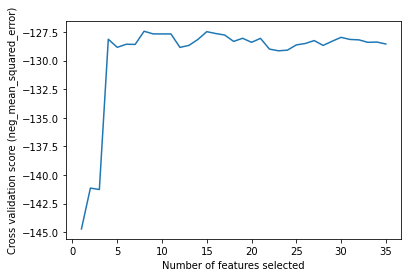

In [339]:
# linear regression
lin_reg = LinearRegression()
lin_rfecv = RFECV(estimator=lin_reg,step=1,cv=2,scoring='neg_mean_squared_error',
             min_features_to_select=min_features_to_select)

lin_rfecv.fit(X_train, y_train_dif)
print("Optimal number of features : %d" % lin_rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg_mean_squared_error)")
plt.plot(
    range(min_features_to_select, len(lin_rfecv.grid_scores_) + min_features_to_select),
    lin_rfecv.grid_scores_,
)
plt.show()

# scores = cross_val_score(lin_reg, X, y_dif, scoring="neg_mean_squared_error", cv=5)
# rmse_scores = np.sqrt(-scores)
# print('Mean: ',rmse_scores.mean())
# print('Std: ',rmse_scores.std())

In [354]:
selected_features = np.ma.compressed(np.ma.masked_array(X.columns,np.invert(lin_rfecv.support_)))

lin_reg = LinearRegression()
lin_reg.fit(X_train[selected_features], y_train_dif)
print(lin_reg.score(X_train[selected_features],y_train_dif))
print(mean_squared_error(y_train_dif,lin_reg.predict(X_train[selected_features]))**0.5)
print(selected_features)

0.42335638882565674
11.010604028646712
['diff_avg_points_for' 'diff_avg_points_against' 'diff_avg_game_margin'
 'diff_pythag_win_pct' 'diff_final_pom' 'diff_pi_i' 'diff_tourneys_car'
 'diff_sw16_car']


In [343]:
lin_reg.coef_

array([-4.28003549,  3.10428375,  5.78067235, -2.35445505, -5.81775989,
        3.09784647, -2.56496173,  3.99163977])

Optimal number of features : 8


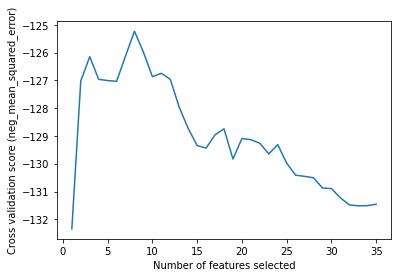

In [347]:
# support vector machine
svr_reg = SVR(kernel='linear')

svr_rfecv = RFECV(estimator=svr_reg,step=1,cv=2,scoring='neg_mean_squared_error',
             min_features_to_select=min_features_to_select)

svr_rfecv.fit(X_train, y_train_dif)
print("Optimal number of features : %d" % svr_rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg_mean_squared_error)")
plt.plot(
    range(min_features_to_select, len(svr_rfecv.grid_scores_) + min_features_to_select),
    svr_rfecv.grid_scores_,
)
plt.show()

# scores = cross_val_score(svr_reg, X, y_dif, scoring="neg_mean_squared_error", cv=5)
# rmse_scores = np.sqrt(-scores)
# print('Mean: ',rmse_scores.mean())
# print('Std: ',rmse_scores.std())

In [355]:
selected_features = np.ma.compressed(np.ma.masked_array(X.columns,np.invert(svr_rfecv.support_)))

svr_reg = SVR(kernel='linear')
svr_reg.fit(X_train[selected_features], y_train_dif)
print(svr_reg.score(X_train[selected_features],y_train_dif))
print(mean_squared_error(y_train_dif,svr_reg.predict(X_train[selected_features]))**0.5)
print(selected_features)

0.4236488031222455
11.007811952013084
['diff_avg_game_margin' 'diff_pythag_win_pct' 'diff_final_net'
 'diff_final_pom' 'diff_pi_i' 'diff_coach_WL_car' 'diff_tourneys_car'
 'diff_sw16_car']


Optimal number of features : 25


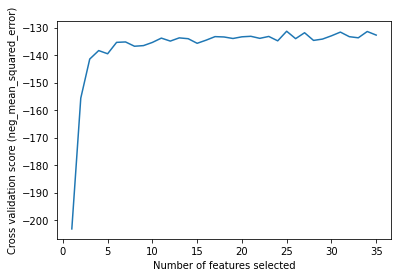

In [358]:
# random forest
forest_reg = RandomForestRegressor()
forest_rfecv = RFECV(estimator=forest_reg,step=1,cv=2,scoring='neg_mean_squared_error',
             min_features_to_select=min_features_to_select)

forest_rfecv.fit(X_train, y_train_dif)
print("Optimal number of features : %d" % forest_rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg_mean_squared_error)")
plt.plot(
    range(min_features_to_select, len(forest_rfecv.grid_scores_) + min_features_to_select),
    forest_rfecv.grid_scores_,
)
plt.show()
# scores = cross_val_score(forest_reg, X, y_dif, scoring="neg_mean_squared_error", cv=5)
# rmse_scores = np.sqrt(-scores)
# print('Mean: ',rmse_scores.mean())
# print('Std: ',rmse_scores.std())

In [362]:
selected_features = np.ma.compressed(np.ma.masked_array(X.columns,np.invert(forest_rfecv.support_)))

forest_reg = RandomForestRegressor()
forest_reg.fit(X_train[selected_features], y_train_dif)
print(forest_reg.score(X_train[selected_features],y_train_dif))
print(mean_squared_error(y_train_dif,forest_reg.predict(X_train[selected_features]))**0.5)
print(selected_features)

0.9090238011083311
4.373421099730032
['diff_win_pct' 'diff_avg_points_for' 'diff_avg_points_against'
 'diff_avg_game_margin' 'diff_std_game_margin' 'diff_close_wins'
 'diff_3FGA_pg' 'diff_3_pct' 'diff_FTA_pg' 'diff_FT_pct' 'diff_TOV_pg'
 'diff_avg_pace' 'diff_off_eff' 'diff_def_eff' 'diff_pythag_win_pct'
 'diff_luck' 'diff_games_vs_tourney_teams' 'diff_final_net'
 'diff_net_improvement' 'diff_final_pom' 'diff_pom_improvement'
 'diff_pi_i' 'diff_coach_WL_car' 'diff_tourneys_car' 'diff_sw16_car']


Optimal number of features : 23


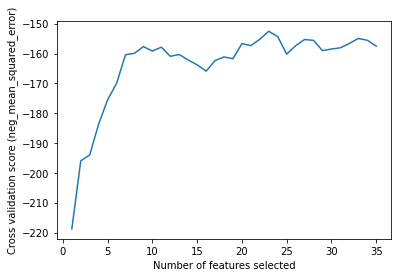

In [361]:
# xgboost
xgb_reg = XGBRegressor()
xgb_rfecv = RFECV(estimator=xgb_reg,step=1,cv=2,scoring='neg_mean_squared_error',
             min_features_to_select=min_features_to_select)

xgb_rfecv.fit(X_train, y_train_dif)
print("Optimal number of features : %d" % xgb_rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg_mean_squared_error)")
plt.plot(
    range(min_features_to_select, len(xgb_rfecv.grid_scores_) + min_features_to_select),
    xgb_rfecv.grid_scores_,
)
plt.show()
# scores = cross_val_score(forest_reg, X, y_dif, scoring="neg_mean_squared_error", cv=5)
# rmse_scores = np.sqrt(-scores)
# print('Mean: ',rmse_scores.mean())
# print('Std: ',rmse_scores.std())

In [363]:
selected_features = np.ma.compressed(np.ma.masked_array(X.columns,np.invert(xgb_rfecv.support_)))

xgb_reg = XGBRegressor()
xgb_reg.fit(X_train[selected_features], y_train_dif)
print(xgb_reg.score(X_train[selected_features],y_train_dif))
print(mean_squared_error(y_train_dif,xgb_reg.predict(X_train[selected_features]))**0.5)
print(selected_features)

0.9987993102498075
0.502426807735927
['diff_FTA_pg' 'diff_FT_pct' 'diff_TOV_pg' 'diff_avg_pace' 'diff_off_eff'
 'diff_def_eff' 'diff_pythag_win_pct' 'diff_luck'
 'diff_wins_vs_tourney_teams' 'diff_away_wins_vs_tourney_teams'
 'diff_losses_vs_tourney_teams' 'diff_losses_vs_non_tourney_teams'
 'diff_games_vs_tourney_teams' 'diff_final_net' 'diff_net_improvement'
 'diff_final_pom' 'diff_pom_improvement' 'diff_pi_i' 'diff_coach_WL_car'
 'diff_tourneys_car' 'diff_sw16_car' 'diff_ff_car' 'diff_champ_car']


In [92]:
from matplotlib.pyplot import figure



<BarContainer object of 23 artists>

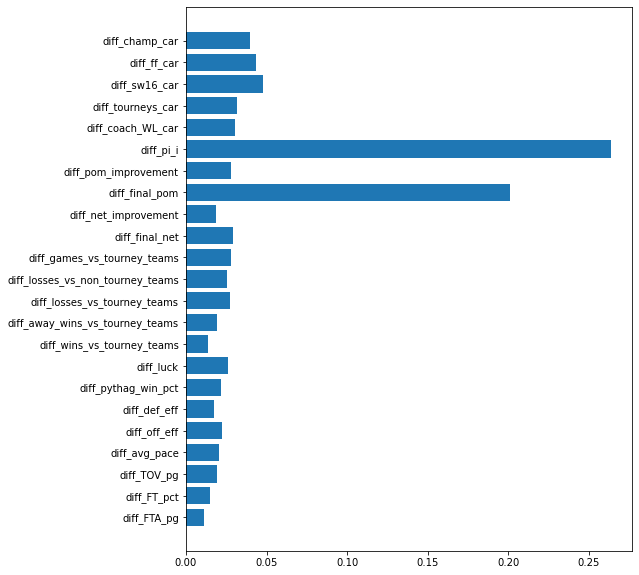

In [366]:
figure(figsize=(8, 10))
plt.barh(selected_features, xgb_reg.feature_importances_)

## 2b) Fine tuning

In [367]:
features = np.ma.compressed(np.ma.masked_array(X.columns,np.invert(lin_rfecv.support_)))

In [443]:
features

array(['diff_final_pom', 'diff_pi_i', 'diff_tourneys_car',
       'diff_sw16_car', 'diff_returning_min_pct',
       'diff_returning_score_pct'], dtype=object)

In [ ]:
xgb_clf

In [334]:
from hyperopt import fmin, tpe, hp, anneal, Trials

In [373]:
def gb_mse_cv(params, random_state=42, cv=2, X=X_train[features], y=y_train_dif):
    # the function gets a set of variable parameters in "param"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']),
              'min_child_weight': params['min_child_weight'],
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree'],
              'eta': params['eta'],
              'gamma': params['gamma'],
              'reg_lambda': params['reg_lambda'],
              'reg_alpha': params['reg_alpha']             
             }
    
    # we use this params to create a new LGBM Regressor
    model = XGBRegressor(random_state=random_state, **params)
    
    # and then conduct the cross validation with the same folds as before
    score = -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error").mean()

    return score

In [374]:
random_state=42

# possible values of parameters
space={'n_estimators': hp.quniform('n_estimators', 100, 2000, 1),
       'max_depth' : hp.quniform('max_depth', 2, 15, 1),
       'min_child_weight': hp.quniform('min_child_weight', 1, 20, 1),
       'subsample': hp.uniform('subsample',0.5,1),
       'colsample_bytree': hp.uniform('colsample_bytree',0.5,1),
       'eta': hp.loguniform('eta', -5, -1),
       'gamma': hp.uniform('gamma', 0,20),
       'reg_lambda': hp.loguniform('reg_lambda',0,7),
       'reg_alpha': hp.uniform('reg_alpha',0,100)       
      }

# trials will contain logging information
trials = Trials()

best=fmin(fn=gb_mse_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=100, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(42) # fixing random state for the reproducibility
         )

print(best)
# # computing the score on the training set
# model = LGBMRegressor(random_state=random_state, n_estimators=int(best['n_estimators']),
#                       max_depth=int(best['max_depth']),learning_rate=best['learning_rate'])
# model.fit(train_data,train_targets)
# sa_test_score=mean_squared_error(test_targets, model.predict(test_data))

# print("Best MSE {:.3f} params {}".format( gb_mse_cv(best), best))

100%|██████████| 100/100 [03:20<00:00,  2.00s/trial, best loss: 127.37956349673848]
{'colsample_bytree': 0.6087692944626087, 'eta': 0.009590545956371677, 'gamma': 13.089787354669978, 'max_depth': 2.0, 'min_child_weight': 16.0, 'n_estimators': 1206.0, 'reg_alpha': 94.95574656425667, 'reg_lambda': 8.074716967351131, 'subsample': 0.7920757818969743}


In [375]:
xgb_reg = XGBRegressor(
    colsample_bytree= best['colsample_bytree'],
    eta = best['eta'],
    gamma = best['gamma'],
    max_depth = int(best['max_depth']),
    min_child_weight = best['min_child_weight'],
    n_estimators = int(best['n_estimators']),
    reg_alpha = best['reg_alpha'],
    reg_lambda = best['reg_lambda'],
    subsample = best['subsample'] 
)

In [378]:
xgb_reg.fit(X_train[features], y_train_dif)
print(xgb_reg.score(X_train[features],y_train_dif))
print(mean_squared_error(y_train_dif,xgb_reg.predict(X_train[features]))**0.5)
print(features)

0.4756493569823418
10.499492426337998
['diff_avg_points_for' 'diff_avg_points_against' 'diff_avg_game_margin'
 'diff_pythag_win_pct' 'diff_final_pom' 'diff_pi_i' 'diff_tourneys_car'
 'diff_sw16_car']
